Write a program that fits the events saved in the file "dati.txt".

Take care to determine the range and binning of the histogram used for the fit based on the events themselves, writing appropriate algorithms to determine the minimum and maximum of the sample and a reasonable estimate of the number of bins to use.

Determine the initial values of the fit parameters using the techniques described in the lesson.

Print the fit result on the screen.

Plot the histogram with the fitted model overlaid.

Which parameters are correlated, and which are anti-correlated with each other?

In [2]:
import numpy as np
import scipy as sp
from scipy.stats import norm, expon
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedBinnedNLL
from math import floor, ceil

In [3]:
data = np.loadtxt("data/dati.txt")

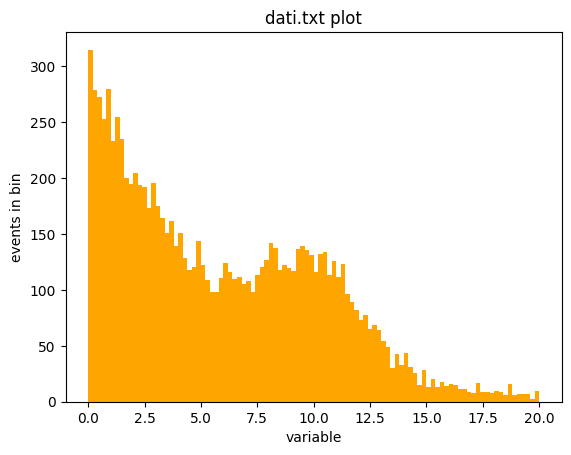

In [4]:
bin_content, bin_edges = np.histogram(data, bins=(floor(len(data)/100)), range=(floor(min(data)), ceil(max(data))))

sample_mean = np.mean(data)
sample_sigma = np.std(data)

fig, ax = plt.subplots()
ax.set_title("dati.txt plot")
ax.set_xlabel('variable')
ax.set_ylabel('events in bin')
ax.hist(data, bins=bin_edges, color="orange")
plt.show()

In [5]:
def cdf(bin_edges, N_signal, mu, sigma, N_background, tau):
    return N_signal * norm.cdf (bin_edges, mu, sigma) + N_background * expon.cdf (bin_edges, 0, tau)

my_cost_func = ExtendedBinnedNLL(bin_content, bin_edges, cdf)

N_events = sum(bin_content)

my_minuit = Minuit (my_cost_func, 
                    N_signal = N_events, mu = sample_mean, sigma = sample_sigma,
                    N_background = N_events, tau = 1.)

my_minuit.limits['N_signal', 'N_background', 'sigma', 'tau'] = (0, None)

First of all, fit of the background

In [6]:
my_minuit.values["N_signal"] = 0
my_minuit.fixed["N_signal", "mu", "sigma"] = True

bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
my_cost_func.mask = (bin_centres < 5) | (15 < bin_centres)

my_minuit.migrad()
my_minuit.minos()
display(my_minuit)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 43.56 (χ²/ndof = 0.9)      │              Nfcn = 142              │
│ EDM = 9.51e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │     0     │   0.1e3   │            │            │    0    │         │  yes  │
│ 1 │ mu           │   5.92    │   0.06    │            │            │         │         │  yes  │
│ 2 │ sigma        │   4.43    │   0.04    │            │            │    0    │         │  yes  │
│ 3 │ N_background │  7.98e3   │  0.13e3   │  -0.13e3   │   0.13e3   │    0    │         │       │
│ 4 │ tau          │    5.2    │    0.1    │    -0.1    │    0.1     │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │     N_background      │          tau          │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.13e3  │  0.13e3   │   -0.1    │    0.1    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │            0            0            0            0        0.000 │
│           mu │            0            0            0            0        0.000 │
│        sigma │            0            0            0            0        0.000 │
│ N_background │            0            0            0     1.71e+04        7.192 │
│          tau │        0.000        0.000        0.000        7.192       0.0106 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

Then, fit of the gaussian values

In [7]:
my_cost_func.mask = None
my_minuit.fixed = False
my_minuit.fixed["N_background", "tau"] = True
my_minuit.values["N_signal"] = N_events - my_minuit.values["N_background"]

my_minuit.migrad()
my_minuit.minos()
display(my_minuit)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 88.68 (χ²/ndof = 0.9)      │              Nfcn = 406              │
│ EDM = 8.41e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │  2.23e3   │  0.07e3   │  -0.07e3   │   0.07e3   │    0    │         │       │
│ 1 │ mu           │   9.99    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ sigma        │   2.04    │   0.06    │   -0.06    │    0.07    │    0    │         │       │
│ 3 │ N_background │  7.98e3   │  0.13e3   │  -0.13e3   │   0.13e3   │    0    │         │  yes  │
│ 4 │ tau          │    5.2    │    0.1    │    -0.1    │    0.1     │    0    │         │  yes  │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │     N_background      │          tau          │       N_signal        │          mu           │         sigma         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.13e3  │  0.13e3   │   -0.1    │    0.1    │    -70    │    70     │   -0.08   │   0.08    │   -0.06   │   0.07    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │      4.9e+03       -1.390        1.744          0e3          0e3 │
│           mu │       -1.390      0.00572       -0.001        0.000        0.000 │
│        sigma │        1.744       -0.001      0.00421        0.000        0.000 │
│ N_background │          0e3        0.000        0.000            0            0 │
│          tau │          0e3        0.000        0.000            0            0 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

Final fit

In [8]:
my_minuit.fixed = False
my_minuit.migrad()
my_minuit.minos()
display(my_minuit)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 87.78 (χ²/ndof = 0.9)      │              Nfcn = 898              │
│ EDM = 5.83e-08 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │  2.31e3   │  0.11e3   │  -0.11e3   │   0.11e3   │    0    │         │       │
│ 1 │ mu           │   9.97    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ sigma        │   2.09    │   0.08    │   -0.08    │    0.08    │    0    │         │       │
│ 3 │ N_background │  7.85e3   │  0.14e3   │  -0.14e3   │   0.14e3   │    0    │         │       │
│ 4 │ tau          │   5.11    │   0.11    │   -0.11    │    0.11    │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │     N_background      │          tau          │       N_signal        │          mu           │         sigma         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.14e3  │  0.14e3   │   -0.11   │   0.11    │  -0.11e3  │  0.11e3   │   -0.08   │   0.08    │   -0.08   │   0.08    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │     1.18e+04       -2.857        5.921     -0.011e6       -8.275 │
│           mu │       -2.857      0.00621       -0.002        3.034        0.001 │
│        sigma │        5.921       -0.002      0.00681       -6.641       -0.005 │
│ N_background │     -0.011e6        3.034       -6.641     2.01e+04       10.022 │
│          tau │       -8.275        0.001       -0.005       10.022       0.0129 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

In [9]:
display(my_minuit.covariance.correlation())

,N_signal,mu,sigma,N_background,tau
N_signal,1,-0.3,0.7,-0.7,-0.7
mu,-0.3,1,-0.4,0.3,0.1
sigma,0.7,-0.4,1,-0.6,-0.5
N_background,-0.7,0.3,-0.6,1,0.6
tau,-0.7,0.1,-0.5,0.6,1


In [10]:
for key in my_minuit.parameters : # parameters is a tuple containing the parameter names
    print ('parameter ' + key + ': ' + 
           str (my_minuit.values[key]) + ' +- ' + 
           str (my_minuit.errors[key]))

parameter N_signal: 2308.151254722085 +- 108.58033541397185
parameter mu: 9.97394336833077 +- 0.07878645358411183
parameter sigma: 2.0865308509703278 +- 0.08254067606311266
parameter N_background: 7848.772942039296 +- 141.92667188969108
parameter tau: 5.112032035829855 +- 0.11349554702790776


(<Figure size 640x480 with 25 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: ylabel='mu'>, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: ylabel='sigma'>, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: ylabel='N_background'>, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: xlabel='N_signal', ylabel='tau'>,
         <AxesSubplot: xlabel='mu'>, <AxesSubplot: xlabel='sigma'>,
         <AxesSubplot: xlabel='N_background'>,
         <AxesSubplot: xlabel='tau'>]], dtype=object))

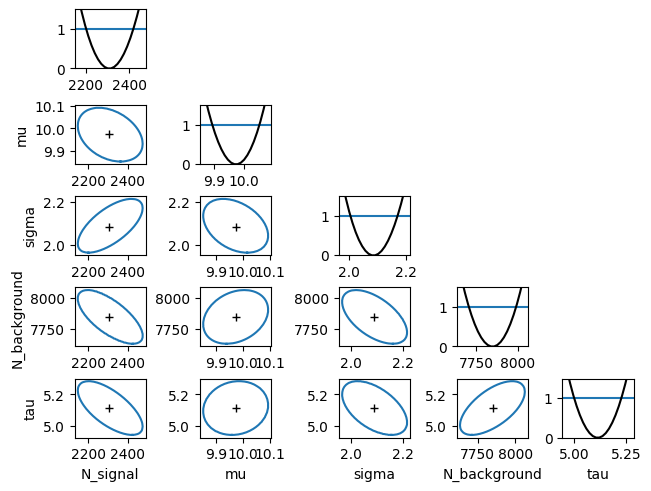

In [11]:
my_minuit.draw_mnmatrix()

(array([ 9.81637046,  9.82723756,  9.83810466,  9.84897175,  9.85983885,
         9.87070595,  9.88157304,  9.89244014,  9.90330724,  9.91417433,
         9.92504143,  9.93590853,  9.94677563,  9.95764272,  9.96850982,
         9.97937692,  9.99024401, 10.00111111, 10.01197821, 10.02284531,
        10.0337124 , 10.0445795 , 10.0554466 , 10.06631369, 10.07718079,
        10.08804789, 10.09891498, 10.10978208, 10.12064918, 10.13151628]),
 array([3.87408745e+00, 3.36532659e+00, 2.89115493e+00, 2.45186617e+00,
        2.04774817e+00, 1.67908290e+00, 1.34614635e+00, 1.04937675e+00,
        7.88627850e-01, 5.64426892e-01, 3.77017490e-01, 2.26638531e-01,
        1.13524064e-01, 3.79031984e-02, 0.00000000e+00, 3.33925270e-05,
        3.82170607e-02, 1.14759356e-01, 2.29863204e-01, 3.83726018e-01,
        5.76539609e-01, 8.08490106e-01, 1.07975787e+00, 1.39030209e+00,
        1.74060375e+00, 2.13068639e+00, 2.56069817e+00, 3.03078055e+00,
        3.54106832e+00, 4.09168953e+00]))

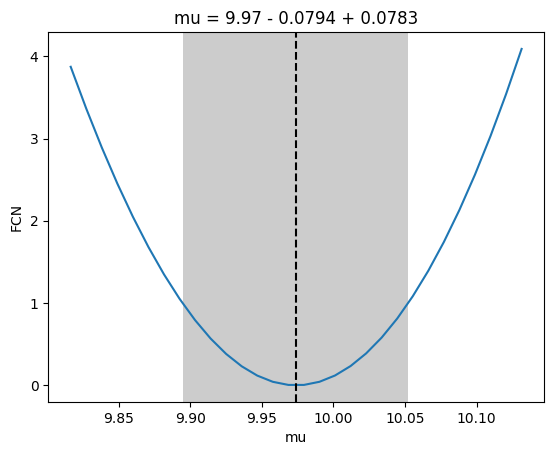

In [14]:
my_minuit.draw_mnprofile("mu")